In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/neural_decoding/
! pwd

/content/drive/MyDrive/neural_decoding
/content/drive/MyDrive/neural_decoding


In [ ]:
! pip install git+https://github.com/yzhang511/clusterless_decoding.git

In [35]:
import os
import sys
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split

from clusterless.utils import IBLDataLoader, ADVIDataLoader, initialize_gmm
from clusterless.advi import ADVI, train_advi, encode_gmm
from clusterless.decoder import (
        discrete_decoder, 
        continuous_decoder, 
        sliding_window, 
        sliding_window_decoder
    )
from clusterless.viz import plot_decoder_input, plot_behavior_traces

In [9]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.set_default_dtype(torch.double)

seed = 666
set_seed(seed)

In [52]:
pid = "dab512bd-a02d-4c1f-8dbc-9155a163efc0"
ephys_path = pid + "/"

In [53]:
# load data 
ibl_data_loader = IBLDataLoader(
    probe_id = pid, 
    ephys_path = ephys_path, 
    behavior_path = None
)

Session ID: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
Probe ID: dab512bd-a02d-4c1f-8dbc-9155a163efc0 (probe00)
number of trials found: 265 (active: 265)
First trial stimulus onset time: 17.56 sec
Last trial stimulus onset time: 2310.24 sec


In [37]:
behavior = ibl_data_loader.load_behaviors("motion_energy", featurize=True)
n_trials, n_t_bins = behavior.shape

In [18]:
behavior.shape

(265, 30)

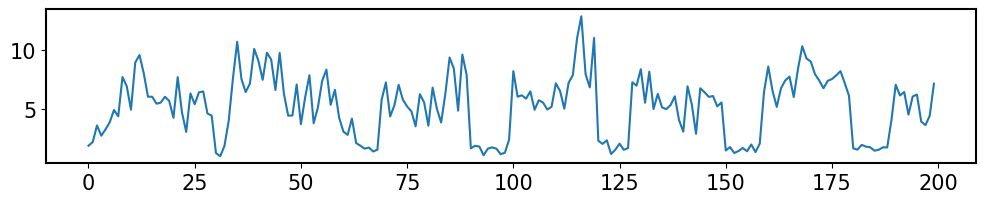

In [21]:
plt.figure(figsize=(12,2))
plt.plot(behavior.flatten()[:200]);

In [49]:
ibl_data_loader.check_available_brain_regions()

['CA1' 'DG-mo' 'DG-po' 'DG-sg' 'Eth' 'LP' 'PO' 'TH' 'VISam5' 'VISam6a'
 'VPLpc' 'alv' 'cing' 'fp' 'ml' 'or']


In [104]:
# load spike sorting data

all_units = np.concatenate(
    # ibl_data_loader.load_all_units(region="all")
    ibl_data_loader.load_all_units(region="lp")
)
ks_all = ibl_data_loader.prepare_decoder_input(
    all_units, is_gmm=False, n_t_bins=n_t_bins, regional=True
)

In [101]:
# (spike_times, spike_units)
all_units.shape

(226212, 2)

In [105]:
# (n_trials, n_neurons, n_time_bins)
ks_all.shape

(265, 128, 30)

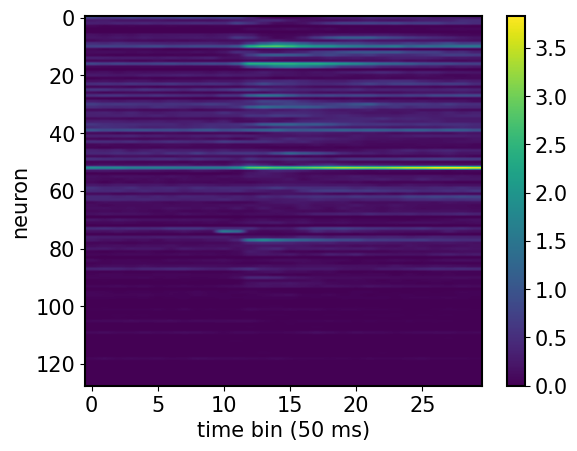

In [106]:
plt.imshow(ks_all.mean(0), aspect="auto")
plt.colorbar()
plt.xlabel("time bin (50 ms)")
plt.ylabel("neuron")
plt.show()

decoding

In [41]:
trial_index = np.arange(n_trials)
random.shuffle(trial_index)

In [42]:
train, test = train_test_split(trial_index, test_size=0.2)

In [107]:
window_y_train, window_y_test, window_y_pred, r2, mse, corr = \
                sliding_window_decoder(
                    ks_all, 
                    behavior, 
                    train, 
                    test,
                )

R2: 0.478, MSE: 4.439, Corr: 0.692


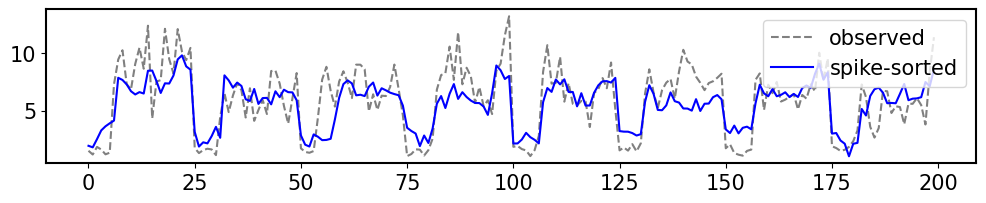

In [108]:
plt.figure(figsize=(12,2))
plt.plot(window_y_test[:200], c="gray", linestyle="--", label="observed")
plt.plot(window_y_pred[:200], c="blue", linestyle="-", label="spike-sorted")
plt.legend()
plt.show()

load unsorted spike data

In [81]:
trials = ibl_data_loader.load_spike_features(region="lp")

Found 82 channels in brain region lp


In [82]:
len(trials)

265

In [83]:
trials[0].shape

(396, 5)

In [84]:
# (spike_times, spike_channels, x, z, maxptp)
trials[0][:5]

array([[ 17.51531538,  13.        ,  20.7857132 , 154.70180943,
          9.7974081 ],
       [ 17.91074473,  13.        ,   5.21275759, 144.95392724,
          5.90885305],
       [ 17.67671375,  14.        ,  59.41924286, 163.20103598,
          9.15839767],
       [ 17.79337924,  14.        ,  49.81912994, 162.58678337,
          6.96032429],
       [ 17.99957717,  14.        ,  60.64374542, 169.34428524,
          4.22820473]])

In [85]:
np.concatenate(trials).shape

(150724, 5)

In [67]:
_, _, x, z, maxptp = np.concatenate(trials).T

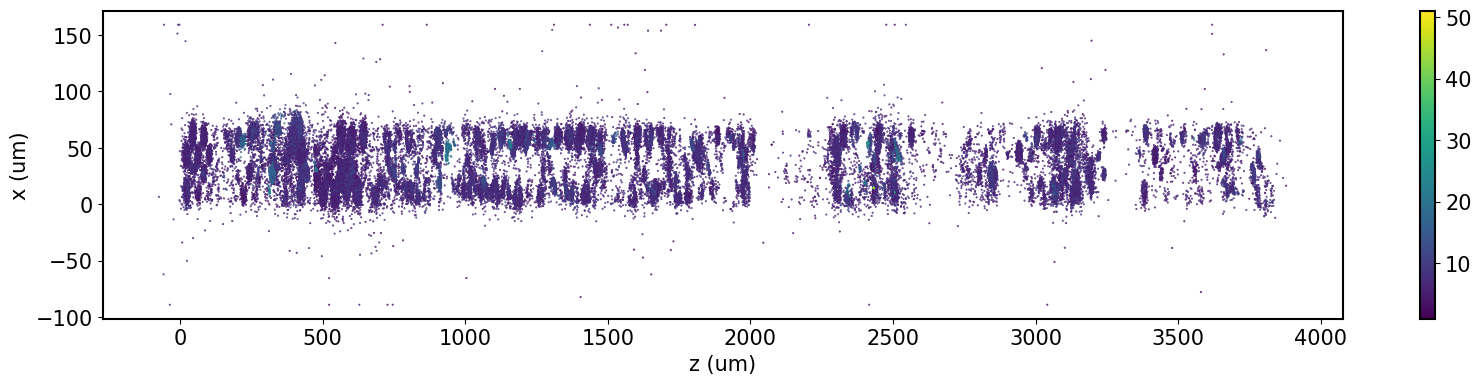

In [71]:
n_spikes_display = 5_0000
plt.figure(figsize=(20,4))
plt.scatter(z[:n_spikes_display], x[:n_spikes_display], c=maxptp[:n_spikes_display], s=.2)
plt.colorbar()
plt.xlabel("z (um)")
plt.ylabel("x (um)")
plt.show()

ADVI Model

In [86]:
advi_data_loader = ADVIDataLoader(
                      data = trials, 
                      behavior = behavior, 
                      n_t_bins = n_t_bins
                )

gmm = initialize_gmm(np.concatenate(trials)[:,1:])
n_t = advi_data_loader.n_t_bins
n_c = gmm.means_.shape[0]
n_d = gmm.means_.shape[1]
print(f"Initializ GMM with {n_c} components and {n_d} spike features.")

Initializ GMM with 112 components and 3 spike features.


In [87]:
train_data, train_ks, train_ts, test_data, test_ks, test_ts = advi_data_loader.split_train_test(train, test)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [88]:
batch_size = 1
max_iter = 50
learning_rate = 1e-3

In [89]:
advi = ADVI(
        n_k=batch_size, 
        n_t=n_t, 
        n_c=n_c, 
        n_d=n_d, 
        init_means=gmm.means_, 
        init_covs=gmm.covariances_
    )

In [90]:
try:
    elbos = train_advi(
        advi,
        s = torch.tensor(train_data[:,1:]), 
        y = torch.tensor(behavior), 
        ks = torch.tensor(train_ks), 
        ts = torch.tensor(train_ts), 
        batch_ids = list(zip(*(iter(train),) * batch_size)), 
        optim = torch.optim.Adam(advi.parameters(), lr=learning_rate), 
        max_iter=max_iter
    )
except ValueError:
    print("Encountered numerical errors during gradient update. Go to the next fold.")

iter: 1 total elbo: -54.94
iter: 2 total elbo: -49.99
iter: 3 total elbo: -46.73
iter: 4 total elbo: -43.63
iter: 5 total elbo: -41.07
iter: 6 total elbo: -38.59
iter: 7 total elbo: -36.64
iter: 8 total elbo: -35.19
iter: 9 total elbo: -33.52
iter: 10 total elbo: -31.84
iter: 11 total elbo: -30.57
iter: 12 total elbo: -29.55
iter: 13 total elbo: -28.54
iter: 14 total elbo: -27.39
iter: 15 total elbo: -26.33
iter: 16 total elbo: -25.67
iter: 17 total elbo: -24.85
iter: 18 total elbo: -24.22
iter: 19 total elbo: -23.66
iter: 20 total elbo: -23.09
iter: 21 total elbo: -22.74
iter: 22 total elbo: -22.21
iter: 23 total elbo: -21.77
iter: 24 total elbo: -21.52
iter: 25 total elbo: -21.17
iter: 26 total elbo: -20.83
iter: 27 total elbo: -20.56
iter: 28 total elbo: -20.33
iter: 29 total elbo: -20.10
iter: 30 total elbo: -19.89
iter: 31 total elbo: -19.68
iter: 32 total elbo: -19.47
iter: 33 total elbo: -19.34
iter: 34 total elbo: -19.21
iter: 35 total elbo: -19.10
iter: 36 total elbo: -18.89
i

In [91]:
# load thresholding data
spike_train = np.concatenate(trials)
spike_times, spike_channels = spike_train[:,0], spike_train[:,1]

In [92]:
thresholded = ibl_data_loader.prepare_decoder_input(
      np.c_[spike_times, spike_channels],
      is_gmm=False, n_t_bins=n_t, regional=False
  )

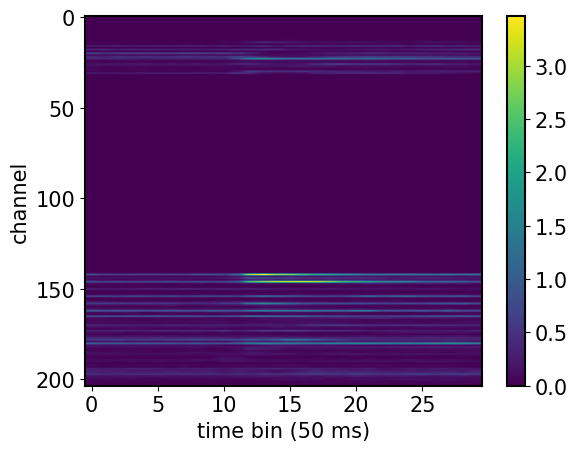

In [93]:
plt.imshow(thresholded.mean(0), aspect="auto")
plt.colorbar()
plt.xlabel("time bin (50 ms)")
plt.ylabel("channel")
plt.show()

In [94]:
y_train, _, y_pred = continuous_decoder(
    thresholded, advi_data_loader.behavior, train, test, 
)

window_y_train, window_y_test, window_y_pred, r2, mse, corr = \
    sliding_window_decoder(
        thresholded, 
        advi_data_loader.behavior, 
        train, 
        test
    )

R2: 0.390, MSE: 5.188, Corr: 0.626


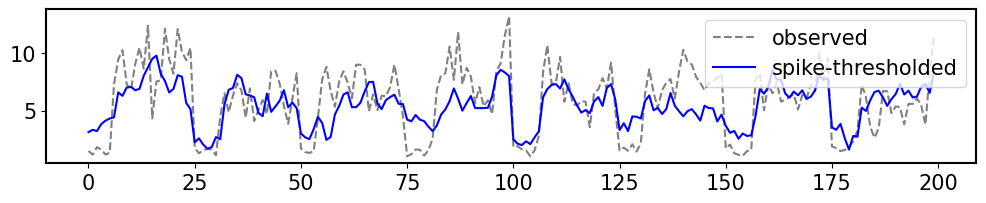

In [95]:
plt.figure(figsize=(12,2))
plt.plot(window_y_test[:200], c="gray", linestyle="--", label="observed")
plt.plot(window_y_pred[:200], c="blue", linestyle="-", label="spike-thresholded")
plt.legend()
plt.show()

In [96]:
# compute posterior dynamic mixture weights

encoded_pis, encoded_weights = encode_gmm(
      advi, advi_data_loader.trials, train, test, y_train, y_pred
  )

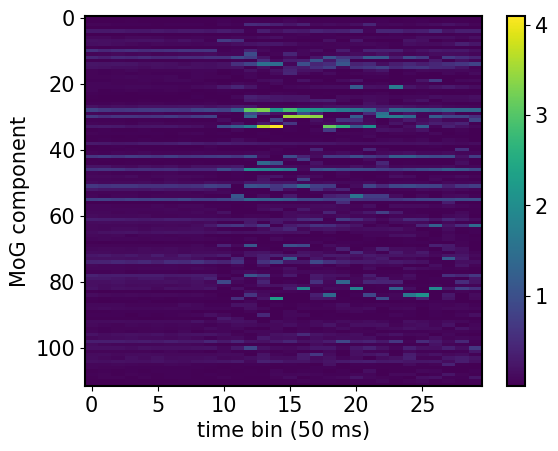

In [97]:
plt.imshow(encoded_weights.mean(0), aspect="auto")
plt.colorbar()
plt.xlabel("time bin (50 ms)")
plt.ylabel("MoG component")
plt.show()

In [98]:
window_y_train, window_y_test, window_y_pred, r2, mse, corr = \
                sliding_window_decoder(
                    encoded_weights, 
                    advi_data_loader.behavior, 
                    train, 
                    test
                )

R2: 0.490, MSE: 4.344, Corr: 0.701


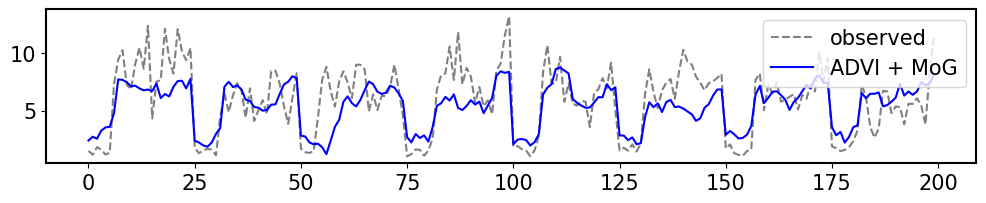

In [99]:
plt.figure(figsize=(12,2))
plt.plot(window_y_test[:200], c="gray", linestyle="--", label="observed")
plt.plot(window_y_pred[:200], c="blue", linestyle="-", label="ADVI + MoG")
plt.legend()
plt.show()